1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [1]:
#load dataset
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

Compute then the cumulative probability $p_i$ (cprob) and sort the maximum speeds from the data. Use then the UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In [2]:
cprob = (np.arange(years_nb, dtype=np.float32) + 1)/(years_nb + 1)
sorted_max_speeds = np.sort(max_speeds)
from scipy.interpolate import UnivariateSpline
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

In [3]:
fifty_prob = 1. - 0.02

So the storm wind speed occurring every 50 years can be guessed as:

In [4]:
fifty_wind = quantile_func(fifty_prob)
fifty_wind      


array(32.97989825)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Time offset for maxT: 6.74+-0.08
Time offset for minT: 7.16+-0.05

 Compability between the two: 4.6 => they are not the same within the fit accuracy


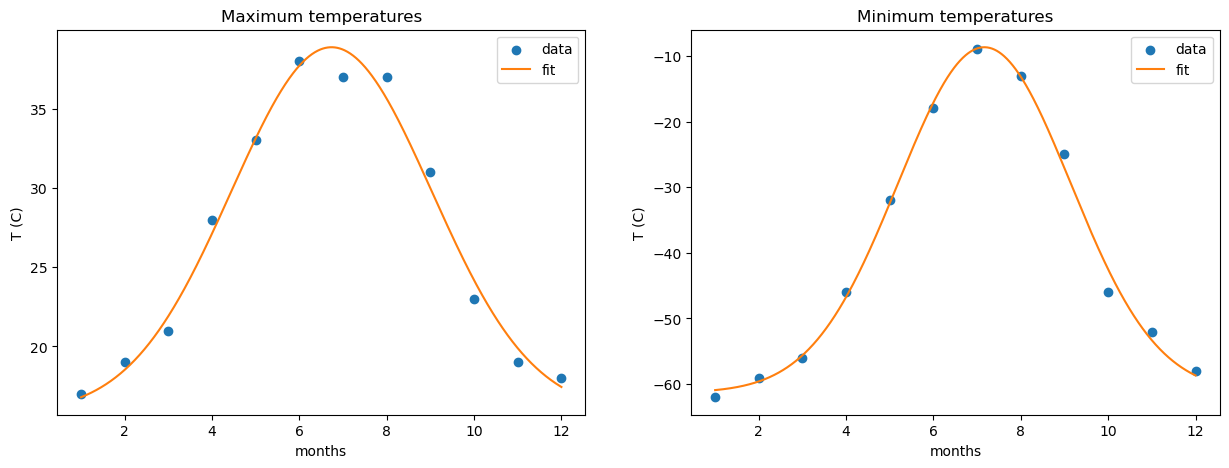

In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

months = [i for i in range(1,13)]
maxT = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
minT = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

# Plot these temperature extremes
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].scatter(months, maxT, label="data")
axes[0].set_title("Maximum temperatures")
axes[0].set_xlabel("months")
axes[0].set_ylabel("T (C)")

axes[1].scatter(months, minT, label="data")
axes[1].set_title("Minimum temperatures")
axes[1].set_xlabel("months")
axes[1].set_ylabel("T (C)")

# Define a function that can describe min and max temperatures
def gaussian(x, A, mu, std, c):
    return A*np.exp(-(x-mu)**2/(2*std**2))+c

# Fit this function to the data with scipy.optimize.curve_fit()
p0_M = [40, 7, 4, 0]
popt_M, pcov_M= curve_fit(gaussian, months, maxT, p0_M)

p0_m = [50, 7, 4, -60]
popt_m, pcov_m= curve_fit(gaussian, months, minT, p0_m)

# Plot the result
x = np.linspace(1, 12, 1000)

axes[0].plot(x, gaussian(x, *popt_M), c="tab:orange", label="fit")
axes[0].legend()
axes[1].plot(x, gaussian(x, *popt_m), c="tab:orange", label="fit")
axes[1].legend()

# Is the time offset for min and max temperatures the same within the fit accuracy?
print("Time offset for maxT: %4.2f+-%4.2f"%(popt_M[1], np.sqrt(pcov_M[1,1])))
print("Time offset for minT: %4.2f+-%4.2f"%(popt_m[1], np.sqrt(pcov_m[1,1])))
comp = abs(popt_M[1]-popt_m[1])/np.sqrt(pcov_m[1,1]+pcov_M[1,1])
print("\n Compability between the two: %3.1f => they are not the same within the fit accuracy"%(comp))

In [6]:
# goodness of the fit
residuals = maxT- gaussian(months, *popt_M)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((maxT-np.mean(maxT))**2)
r_squared_M = 1 - (ss_res/ss_tot)

residuals = minT- gaussian(months, *popt_m)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((minT-np.mean(minT))**2)
r_squared_m = 1 - (ss_res/ss_tot)

print("The fit is good? Look at R^2: \n maxT->%4.3f \n minT->%4.3f \nIt seems good"%(r_squared_M, r_squared_m))

The fit is good? Look at R^2: 
 maxT->0.986 
 minT->0.995 
It seems good


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

The first minima found is [-0.08984202  0.71265641] with value: -1.0316284534898768
The second minima found is [ 0.08984201 -0.71265642] with value: -1.0316284534898743
The minima with initial guess (0, 0) is [0. 0.]


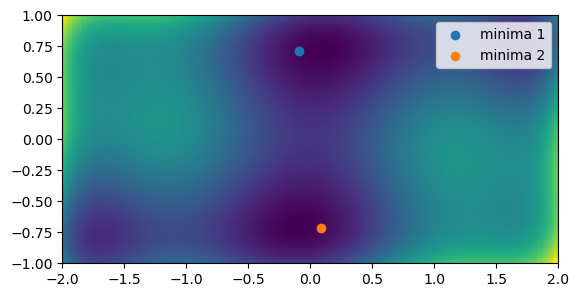

In [8]:
def f(X):
    x = X[0]
    y = X[1]
    return (4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)

mesh = np.meshgrid(x, y)
plt.imshow(f(mesh), extent=(-2, 2, -1, 1))

# fin global minima of this function
minima_list = []
minima = minimize(f, (0, 0.75))
print("The first minima found is", minima["x"], "with value:", minima["fun"])
plt.scatter(minima["x"][0], minima["x"][1], label="minima 1")
minima_list.append(minima)

minima = minimize(f, (0, -0.75))
print("The second minima found is", minima["x"], "with value:", minima["fun"])
plt.scatter(minima["x"][0], minima["x"][1], label="minima 2")
minima_list.append(minima)

# What happens for an initial guess of (x, y) = (0, 0)?
solution = minimize(f, (0, 0))
print("The minima with initial guess (0, 0) is", solution["x"])

plt.legend()

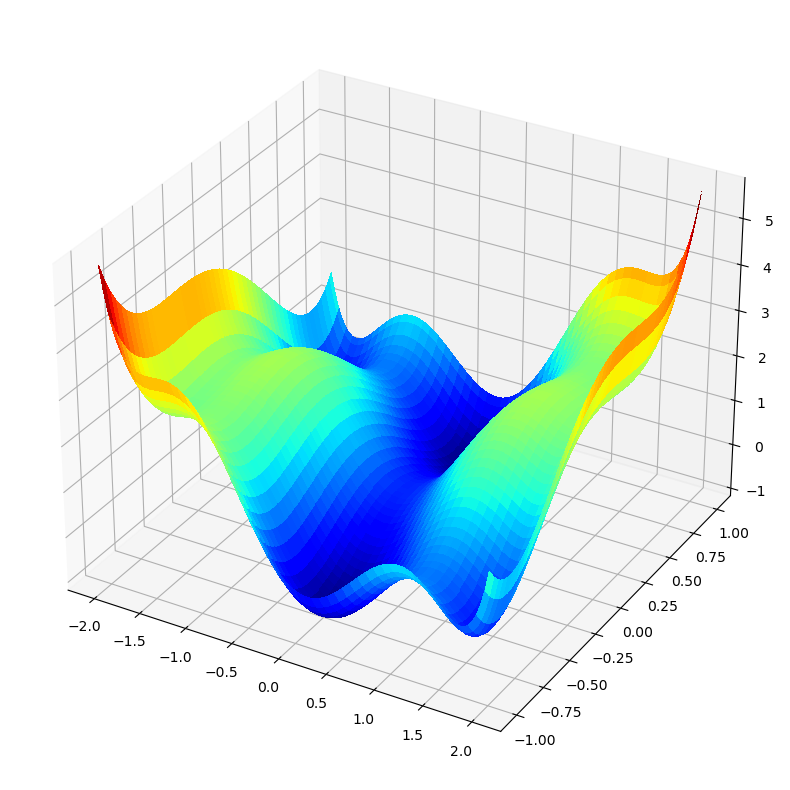

In [9]:
# Plot the surface for a better interpretation
#%matplotlib widget
%matplotlib inline

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
surf = ax.plot_surface(mesh[0], mesh[1], f(mesh), cmap="jet",
                       linewidth=0, antialiased=False)

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

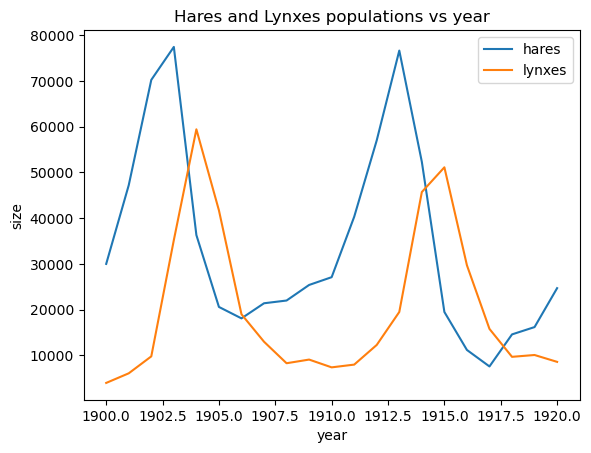

In [10]:
populations = np.loadtxt('populations.txt')

year    = populations[:,0]
hares   = populations[:,1]
lynxes  = populations[:,2]
#carrots = populations[:,3]

# plot the 2 populations over the years
plt.plot(year, hares, label = "hares")
plt.plot(year, lynxes, label = "lynxes")
#plt.plot(year, carrots, label = "carrots")
plt.xlabel("year")
plt.ylabel("size")
plt.title("Hares and Lynxes populations vs year")
plt.legend()
plt.show()

Hares  peak frequency: 0.0952
Lynxes peak frequency: 0.0952


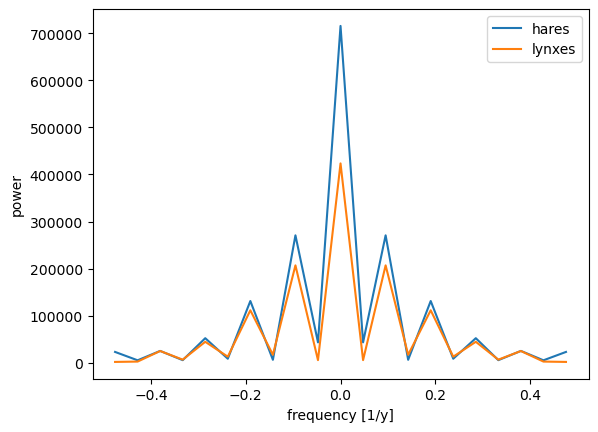

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
from scipy import fftpack
from matplotlib.colors import LogNorm

# compute FFT of the two populations
hares_fft  = fftpack.fft(hares)
lynxes_fft = fftpack.fft(lynxes)

# compute the powers
hares_fft_pow  = np.abs(hares_fft)
lynxes_fft_pow = np.abs(lynxes_fft)

# return corresponding frequencies 
freqs  = fftpack.fftfreq(len(year), d=1)

idx = np.argsort(freqs)
#freqs = freqs[idx]
#hares_fft_pow  = hares_fft_pow[idx]
#lynxes_fft_pow = lynxes_fft_pow[idx]

# plot
plt.plot(freqs[idx], hares_fft_pow[idx], label="hares")
plt.plot(freqs[idx], lynxes_fft_pow[idx], label="lynxes")
plt.xlabel('frequency [1/y]')
plt.ylabel('power')
plt.legend()

# find the max peaks and respective freqs
pos_mask = np.where(freqs > 0)
hares_peak_freq  = freqs[pos_mask][hares_fft_pow[pos_mask].argmax()]
lynxes_peak_freq = freqs[pos_mask][lynxes_fft_pow[pos_mask].argmax()]

print("Hares  peak frequency: %5.4f"%(hares_peak_freq))
print("Lynxes peak frequency: %5.4f"%(lynxes_peak_freq))

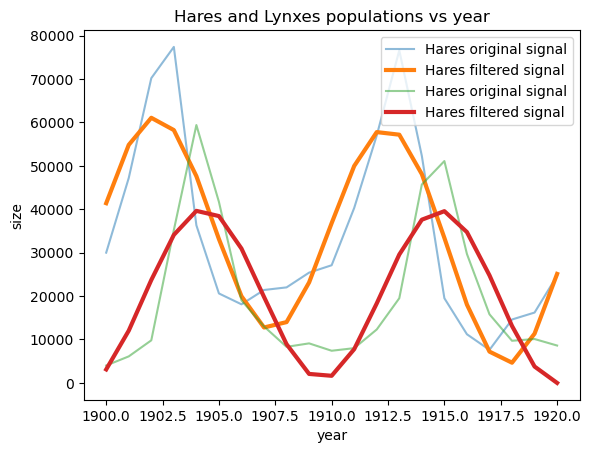

In [12]:
# filter (set to zero) all high frequency components that are larger than peak_freq
hares_hig_freqs, lynxes_hig_freqs = hares_fft.copy(), lynxes_fft.copy()

hares_hig_freqs[np.abs(freqs)>hares_peak_freq]   = 0
lynxes_hig_freqs[np.abs(freqs)>lynxes_peak_freq] = 0

# calculate the Inverse Fast Fourier Transform
filtered_hares = np.real(fftpack.ifft(hares_hig_freqs))
filtered_lynxes = np.real(fftpack.ifft(lynxes_hig_freqs))


# plot the result of the IFFT
plt.plot(year, hares, alpha=0.5, label='Hares original signal')
plt.plot(year, filtered_hares, linewidth=3, label='Hares filtered signal')
plt.plot(year, lynxes, alpha=0.5, label='Hares original signal')
plt.plot(year, filtered_lynxes, linewidth=3, label='Hares filtered signal')
plt.xlabel('year')
plt.ylabel('size')
plt.title("Hares and Lynxes populations vs year")
plt.legend()

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

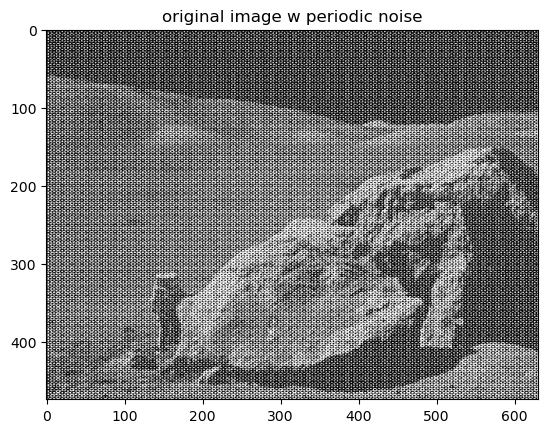

In [13]:
# Import the image as a 2D numpy array
from scipy import fftpack
from matplotlib.colors import LogNorm
image = plt.imread("moonlanding.png")
plt.imshow(image, cmap='gray')
plt.title("original image w periodic noise")
plt.show()

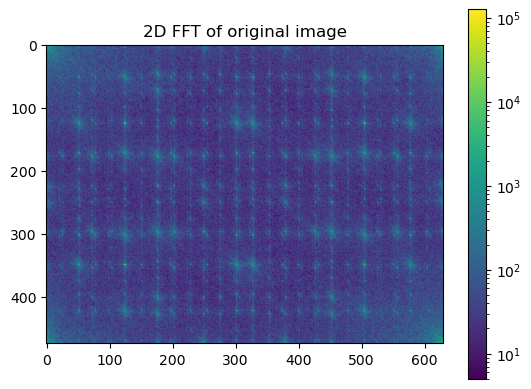

In [14]:
# Perform a 2D FFT
image_fft = fftpack.fft2(image)
plt.imshow(np.abs(image_fft), norm=LogNorm(vmin=5, vmax=np.abs(image_fft).max()))
plt.title("2D FFT of original image")
plt.colorbar()
plt.show()

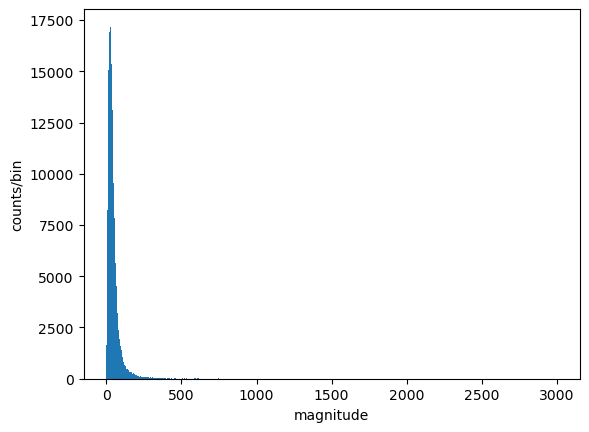

In [15]:
# Inspect the spectrum, and try to locate the regions of the power spectrum 
# that contain the signal and those which contain the periodic noise

magnitudes = np.reshape(np.abs(image_fft), (np.prod(image_fft.shape)))
plt.hist(magnitudes, bins=1000, range=[0,3000])
plt.xlabel("magnitude")
plt.ylabel("counts/bin")
plt.show()

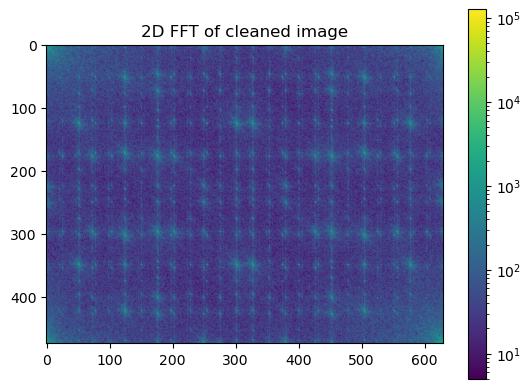

In [16]:
# Trying to cancel out higher magnitude regions
filtered_image_fft = image_fft.copy()
filtered_image_fft[np.abs(image_fft)>3000]=0
plt.imshow(np.abs(filtered_image_fft), norm=LogNorm(vmin=5, vmax=np.abs(image_fft).max()))
plt.title("2D FFT of cleaned image")
plt.colorbar()
plt.show()

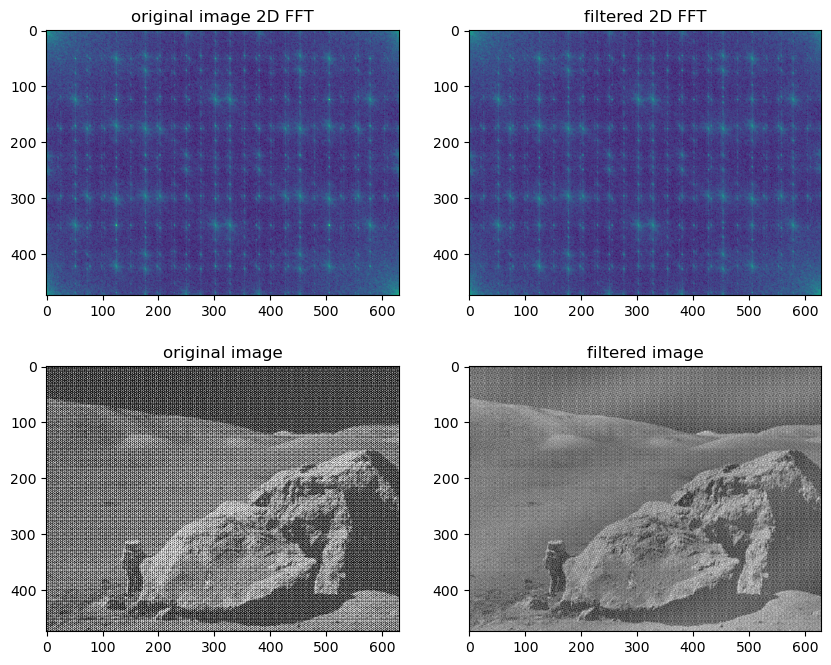

In [17]:
# Apply the inverse Fourier transform to plot the resulting image
filtered_image = np.real(fftpack.ifft2(filtered_image_fft))

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].imshow(np.abs(image_fft), norm=LogNorm(vmin=5, vmax=np.abs(image_fft).max()))
ax[0, 0].set_title("original image 2D FFT")
ax[0, 1].imshow(np.abs(filtered_image_fft), norm=LogNorm(vmin=5, vmax=np.abs(image_fft).max()))
ax[0, 1].set_title("filtered 2D FFT")
ax[1, 0].imshow(image, cmap='gray')
ax[1, 0].set_title("original image")
ax[1, 1].imshow(filtered_image, cmap='gray')
ax[1, 1].set_title("filtered image")
plt.show()